# SARIMA Model - Wage Rate ($)

Training (1997-2020), Training (2021-2023)

# Packages & Data Loading

## Packages

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import gdown
import requests
import warnings
from io import StringIO

import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Show graphs
%matplotlib inline

## Data Loading

In [3]:
# Google Drive file
file_id = '117pk3NKZPfYmHQyP452HeMV7_8Jq6_W0'

# Create the download URL
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Use requests to get file content
response = requests.get(download_url)
response.raise_for_status()  

# Load the CSV directly into df
csv_data = StringIO(response.text)
df = pd.read_csv(csv_data)

# Display data
print('Shape of the dataset:', df.shape)
print(df.dtypes)

Shape of the dataset: (349920, 14)
ref_date                   object
geo                        object
labour_force               object
industry                   object
sex                        object
age_group                  object
value_unemployment        float64
wages                      object
value_wage                float64
year                        int64
month                       int64
ref_date_numeric          float64
value_unemployment_log    float64
value_wage_log            float64
dtype: object


In [4]:
# Create a copy with selected columns
df_var = df[['ref_date', 'value_wage']].copy()

print(df_var.head())

     ref_date  value_wage
0  1997-01-01        7.00
1  1997-01-01        8.00
2  1997-01-01        7.50
3  1997-01-01        7.00
4  1997-01-01        9.49


In [5]:
# Group df_var by 'ref_date' and calculate the median 'value_unemployment'
df_sarima = df_var.groupby('ref_date').agg(
    median_wage=('value_wage', 'median')  # Calculate the median 
).reset_index()

print(df_sarima)

       ref_date  median_wage
0    1997-01-01    12.375000
1    1997-02-01    12.695000
2    1997-03-01    12.511667
3    1997-04-01    12.585000
4    1997-05-01    12.000000
..          ...          ...
319  2023-08-01    26.037639
320  2023-09-01    27.000000
321  2023-10-01    26.670000
322  2023-11-01    27.000000
323  2023-12-01    27.400000

[324 rows x 2 columns]


In [6]:
# Display shape and data types 
print('Shape of the dataset:\n', df_var.shape)
print(df_sarima.dtypes)

# Convert 'ref_date' to datetime
df_sarima['ref_date'] = pd.to_datetime(df_sarima['ref_date'])

# Set 'ref_date' as the index 
df_sarima = df_sarima.set_index('ref_date')

# Verify the index is set and DatetimeIndex
print('\n\nIndex after setting ref_date:\n', df_sarima.head().index)
print('\n\nData types after setting index:\n', df_sarima.dtypes)
print('\n\nDataset:\n', df_sarima.head(2))

Shape of the dataset:
 (349920, 2)
ref_date        object
median_wage    float64
dtype: object


Index after setting ref_date:
 DatetimeIndex(['1997-01-01', '1997-02-01', '1997-03-01', '1997-04-01',
               '1997-05-01'],
              dtype='datetime64[ns]', name='ref_date', freq=None)


Data types after setting index:
 median_wage    float64
dtype: object


Dataset:
             median_wage
ref_date               
1997-01-01       12.375
1997-02-01       12.695


# Visualization

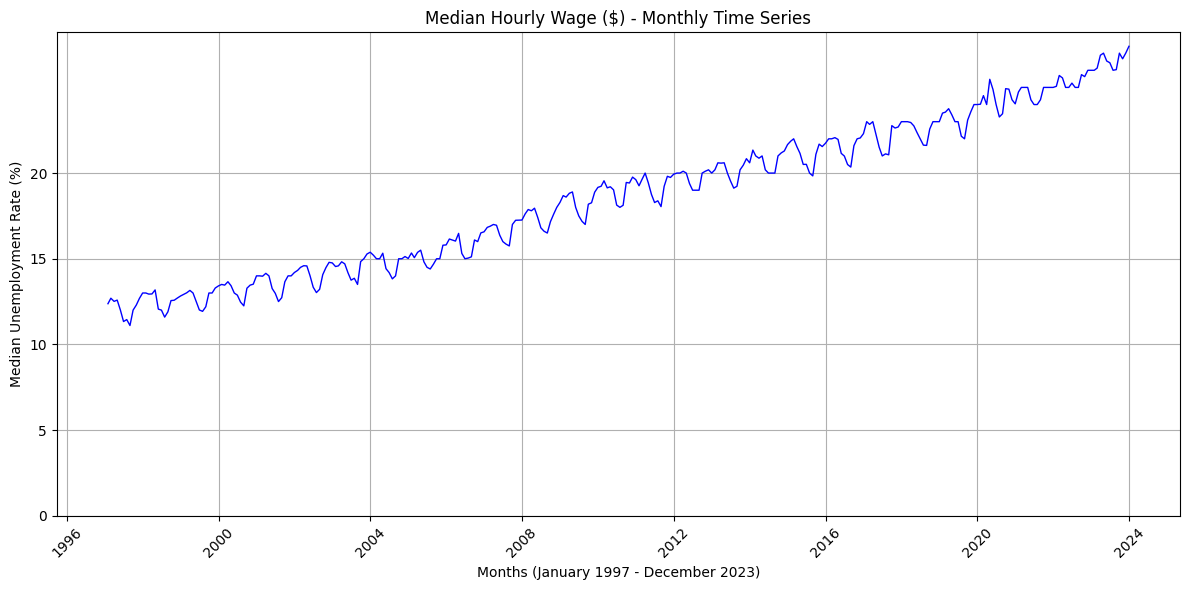

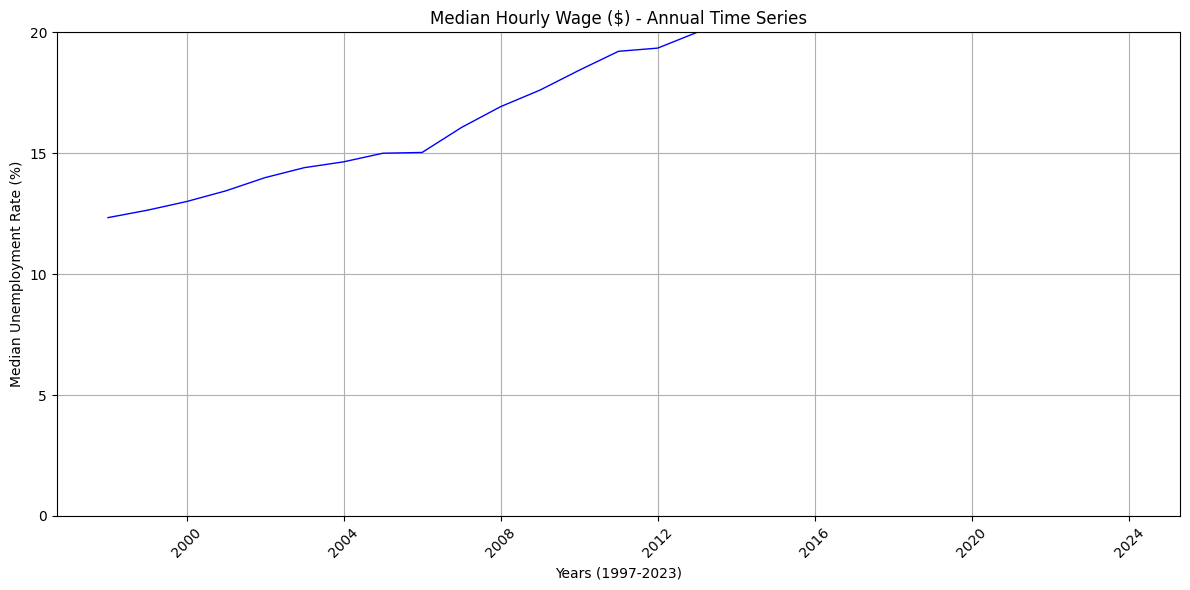

In [7]:
# Resampling to monthly 
df_monthly = df_sarima.resample('ME').median()

# Resampling to yearly 
df_annual = df_sarima.resample('YE').median()

# Set y-axis limits and tick intervals
y_min = 0
y_max = 20
y_ticks = range(y_min, y_max + 1, 5)

# Plot the monthly median unemployment rate
plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly, color='blue', linewidth=1)
plt.title('Median Hourly Wage ($) - Monthly Time Series')
plt.xlabel('Months (January 1997 - December 2023)')
plt.ylabel('Median Unemployment Rate (%)')
plt.xticks(rotation=45)
plt.yticks(y_ticks)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the yearly median unemployment rate
plt.figure(figsize=(12, 6))
plt.plot(df_annual.index, df_annual, color='blue', linewidth=1)
plt.title('Median Hourly Wage ($) - Annual Time Series')
plt.xlabel('Years (1997-2023)')
plt.ylabel('Median Unemployment Rate (%)')
plt.xticks(rotation=45)
plt.ylim(y_min, y_max)
plt.yticks(y_ticks)
plt.grid(True)
plt.tight_layout()
plt.show()

# Stationarity

## ADF

Augmented Dickey-Fuller (ADF) Test

In [8]:
# Perform ADF test 
adf_test = adfuller(df_sarima)
print("\nADF Test Results:")
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] < 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary. Differencing may be required.")


ADF Test Results:
ADF Statistic: 2.116022002061713
p-value: 0.998805980482922
The data is not stationary. Differencing may be required.


## ACF & PACF

Autocorrelation Function (ACF) & Partial Autocorrelation Function (PACF)

Data Summary:
       median_wage
count   324.000000
mean     18.589238
std       4.331917
min      11.102143
25%      14.590625
50%      18.949167
75%      22.000000
max      27.400000


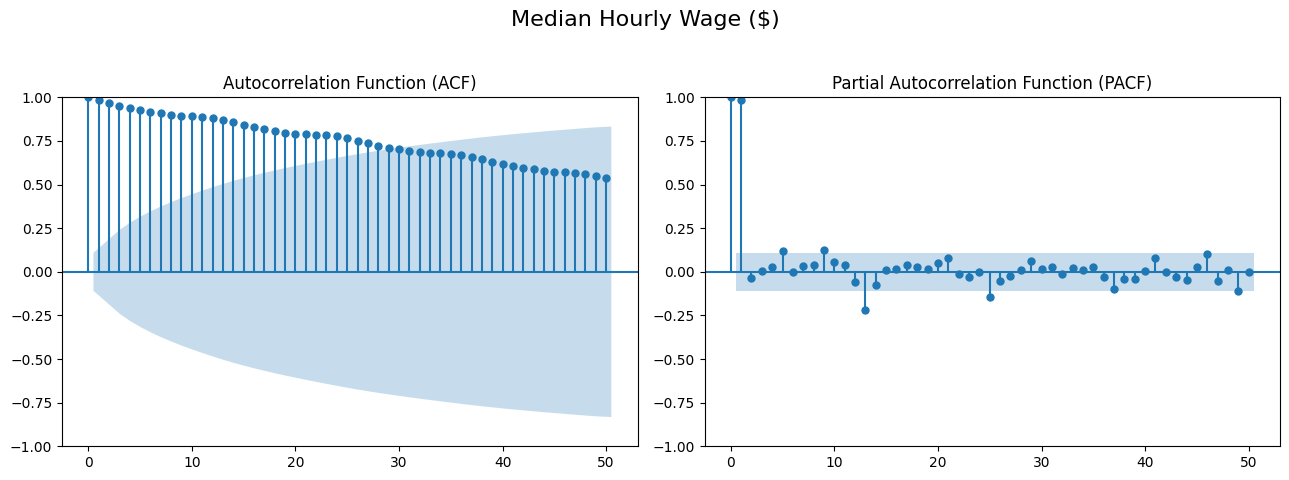

In [9]:
# Define function 
def acf_pacf_plotter(data, nlag=50, alpha=0.05, fig_size=(13, 5)):
        # Check and print descriptives
    print("Data Summary:")
    print(data.describe())

    # Create figure
    plt.figure(figsize=fig_size)
    layout = (1, 2)  

    # Assign axes 
    ax_acf = plt.subplot2grid(layout, (0, 0))  # Left side for ACF
    ax_pacf = plt.subplot2grid(layout, (0, 1))  # Right side for PACF

    # Plot ACF and PACF 
    plot_acf(data, alpha=alpha, lags=nlag, ax=ax_acf)
    plot_pacf(data, alpha=alpha, lags=nlag, ax=ax_pacf)

    # Set titles
    ax_acf.set_title('Autocorrelation Function (ACF)')
    ax_pacf.set_title('Partial Autocorrelation Function (PACF)')

    # Add figure title
    plt.suptitle('Median Hourly Wage ($)', fontsize=16)

    # Adjust layout 
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Show figure
    plt.show()

# Use Function with data
acf_pacf_plotter(df_sarima, nlag=50)


## *Stationarity Conclusion*

The data was not stationary. Therefore, further transformation steps are required to make the data stationary. 

Seasonal differencing will be implemented to remove seasonal trends and make the data stationary. 

# Seasonality

## Seasonal Differencing (D)

In [10]:
# Seasonal differencing
df_arima_seasonal_diff = df_sarima.diff(12).dropna()

In [11]:
# Perform ADF test 
adf_test = adfuller(df_arima_seasonal_diff )
print("\nADF Test Results:")
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] < 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary. Differencing may be required.")


ADF Test Results:
ADF Statistic: -3.607816471333273
p-value: 0.00561333992738165
The data is stationary.


## Seasonal AR (P) and MA (Q)

Data Summary:
       median_wage
count   312.000000
mean      0.554677
std       0.393666
min      -0.598571
25%       0.297625
50%       0.531786
75%       0.793214
max       2.062222


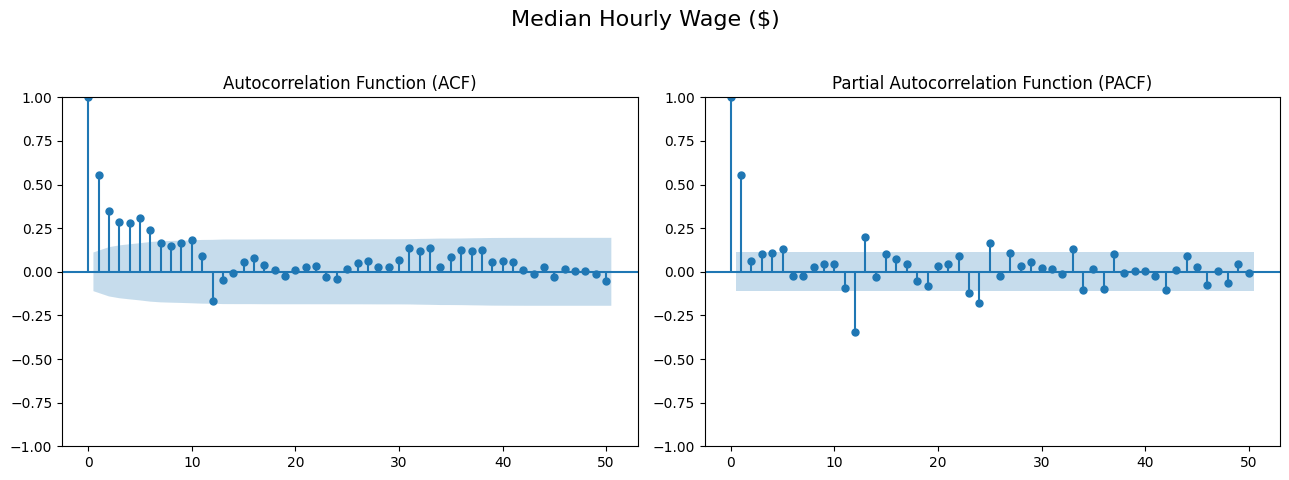

In [12]:
# Define function 
def acf_pacf_plotter(data, nlag=50, alpha=0.05, fig_size=(13, 5)):
    # Check and print descriptives
    print("Data Summary:")
    print(data.describe())

    # Create figure
    plt.figure(figsize=fig_size)
    layout = (1, 2)  

    # Assign axes 
    ax_acf = plt.subplot2grid(layout, (0, 0))  # Left side for ACF
    ax_pacf = plt.subplot2grid(layout, (0, 1))  # Right side for PACF

    # Plot ACF and PACF with lags up to 25
    plot_acf(data, alpha=alpha, lags=nlag, ax=ax_acf)
    plot_pacf(data, alpha=alpha, lags=nlag, ax=ax_pacf)

    # Set titles
    ax_acf.set_title('Autocorrelation Function (ACF)')
    ax_pacf.set_title('Partial Autocorrelation Function (PACF)')

    # Add figure title
    plt.suptitle('Median Hourly Wage ($)', fontsize=16)

    # Adjust layout 
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Show figure
    plt.show()

# Use Function with data
acf_pacf_plotter(df_arima_seasonal_diff, nlag=50)

## *Seasonality Conclusion*

Seasonal differencing has effectively removed the seasonal trends and made the data stationary.

# SARIMA Parameters

## Parameter Testing

In [13]:
warnings.filterwarnings("ignore")

data = df_sarima

# Define parameter ranges for non-seasonal components
p = range(0, 3)  # Non-seasonal AR 
d = range(0, 2)  # Non-seasonal differencing
q = range(0, 3)  # Non-seasonal MA 

# Define parameter ranges for seasonal components
P = range(0, 3)  # Seasonal AR 
D = range(0, 2)  # Seasonal differencing
Q = range(0, 3)  # Seasonal MA 
m = [12]         # Seasonal period 

# Generate all combinations of non-seasonal and seasonal parameters
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, m))

# Initialize variables to store best AIC value and best parameter set
best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None

# Grid Search: Iterate through all combinations of pdq and seasonal_pdq
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            # Fit SARIMA model
            model = SARIMAX(data, 
                            order=param, 
                            seasonal_order=seasonal_param, 
                            enforce_stationarity=False, 
                            enforce_invertibility=False)
            model_fit = model.fit(disp=False)

            # Evaluate using AIC
            current_aic = model_fit.aic

            # Store lowest AIC
            if current_aic < best_aic:
                best_aic = current_aic
                best_pdq = param
                best_seasonal_pdq = seasonal_param

            # Print iteration result
            print(f"SARIMA{param}x{seasonal_param} AIC: {current_aic:.2f}")

        except Exception as e:
            # Print error for invalid combinations
            print(f"Error for SARIMA{param}x{seasonal_param}: {e}")
            continue

# Print best model parameters and lowest AIC
if best_pdq and best_seasonal_pdq:
    print(f"\nBest SARIMA model: {best_pdq}x{best_seasonal_pdq} with AIC: {best_aic:.2f}")
else:
    print("\nNo valid SARIMA model was found.")


SARIMA(0, 0, 0)x(0, 0, 0, 12) AIC: 2824.23
SARIMA(0, 0, 0)x(0, 0, 1, 12) AIC: 2731.49
SARIMA(0, 0, 0)x(0, 0, 2, 12) AIC: 1946.63
SARIMA(0, 0, 0)x(0, 1, 0, 12) AIC: 644.68
SARIMA(0, 0, 0)x(0, 1, 1, 12) AIC: 556.85
SARIMA(0, 0, 0)x(0, 1, 2, 12) AIC: 513.11
SARIMA(0, 0, 0)x(1, 0, 0, 12) AIC: 291.48
SARIMA(0, 0, 0)x(1, 0, 1, 12) AIC: 273.53
SARIMA(0, 0, 0)x(1, 0, 2, 12) AIC: 269.95
SARIMA(0, 0, 0)x(1, 1, 0, 12) AIC: 490.67
SARIMA(0, 0, 0)x(1, 1, 1, 12) AIC: 327.37
SARIMA(0, 0, 0)x(1, 1, 2, 12) AIC: 298.19
SARIMA(0, 0, 0)x(2, 0, 0, 12) AIC: 270.03
SARIMA(0, 0, 0)x(2, 0, 1, 12) AIC: 270.75
SARIMA(0, 0, 0)x(2, 0, 2, 12) AIC: 269.75
SARIMA(0, 0, 0)x(2, 1, 0, 12) AIC: 410.17
SARIMA(0, 0, 0)x(2, 1, 1, 12) AIC: 306.31
SARIMA(0, 0, 0)x(2, 1, 2, 12) AIC: 306.94
SARIMA(0, 0, 1)x(0, 0, 0, 12) AIC: 2387.60
SARIMA(0, 0, 1)x(0, 0, 1, 12) AIC: 2315.50
SARIMA(0, 0, 1)x(0, 0, 2, 12) AIC: 1573.68
SARIMA(0, 0, 1)x(0, 1, 0, 12) AIC: 440.03
SARIMA(0, 0, 1)x(0, 1, 1, 12) AIC: 412.33
SARIMA(0, 0, 1)x(0, 1, 2, 12

In [14]:
warnings.filterwarnings("ignore")

# Use your original data
data = df_sarima

# Define parameter ranges for non-seasonal components
p = range(0, 3)  # Non-seasonal AR terms
d = range(0, 2)  # Non-seasonal differencing
q = range(0, 3)  # Non-seasonal MA terms

# Define parameter ranges for seasonal components
P = range(0, 3)  # Seasonal AR terms
D = range(0, 2)  # Seasonal differencing
Q = range(0, 3)  # Seasonal MA terms
m = [12]         # Seasonal period 

# Generate all combinations of non-seasonal and seasonal parameters
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, m))

# Initialize variables to store best BIC value and best parameter set
best_bic = float("inf")
best_pdq = None
best_seasonal_pdq = None

# Grid Search: Iterate through all combinations of pdq and seasonal_pdq
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            # Fit SARIMA model
            model = SARIMAX(data, 
                            order=param, 
                            seasonal_order=seasonal_param, 
                            enforce_stationarity=False, 
                            enforce_invertibility=False)
            model_fit = model.fit(disp=False)

            # Evaluate using BIC
            current_bic = model_fit.bic

            # Store lowest BIC
            if current_bic < best_bic:
                best_bic = current_bic
                best_pdq = param
                best_seasonal_pdq = seasonal_param

            # Print iteration result
            print(f"SARIMA{param}x{seasonal_param} BIC: {current_bic:.2f}")

        except Exception as e:
            # Skip models that fail to converge or cause errors
            print(f"Error for SARIMA{param}x{seasonal_param}: {e}")
            continue

# Print best model parameters and lowest BIC
if best_pdq and best_seasonal_pdq:
    print(f"\nBest SARIMA model: {best_pdq}x{best_seasonal_pdq} with BIC: {best_bic:.2f}")
else:
    print("\nNo valid SARIMA model was found.")


SARIMA(0, 0, 0)x(0, 0, 0, 12) BIC: 2828.01
SARIMA(0, 0, 0)x(0, 0, 1, 12) BIC: 2738.97
SARIMA(0, 0, 0)x(0, 0, 2, 12) BIC: 1957.73
SARIMA(0, 0, 0)x(0, 1, 0, 12) BIC: 648.42
SARIMA(0, 0, 0)x(0, 1, 1, 12) BIC: 564.25
SARIMA(0, 0, 0)x(0, 1, 2, 12) BIC: 524.09
SARIMA(0, 0, 0)x(1, 0, 0, 12) BIC: 298.97
SARIMA(0, 0, 0)x(1, 0, 1, 12) BIC: 284.75
SARIMA(0, 0, 0)x(1, 0, 2, 12) BIC: 284.75
SARIMA(0, 0, 0)x(1, 1, 0, 12) BIC: 498.08
SARIMA(0, 0, 0)x(1, 1, 1, 12) BIC: 338.47
SARIMA(0, 0, 0)x(1, 1, 2, 12) BIC: 312.83
SARIMA(0, 0, 0)x(2, 0, 0, 12) BIC: 281.14
SARIMA(0, 0, 0)x(2, 0, 1, 12) BIC: 285.56
SARIMA(0, 0, 0)x(2, 0, 2, 12) BIC: 288.25
SARIMA(0, 0, 0)x(2, 1, 0, 12) BIC: 421.16
SARIMA(0, 0, 0)x(2, 1, 1, 12) BIC: 320.96
SARIMA(0, 0, 0)x(2, 1, 2, 12) BIC: 325.24
SARIMA(0, 0, 1)x(0, 0, 0, 12) BIC: 2395.15
SARIMA(0, 0, 1)x(0, 0, 1, 12) BIC: 2326.71
SARIMA(0, 0, 1)x(0, 0, 2, 12) BIC: 1588.47
SARIMA(0, 0, 1)x(0, 1, 0, 12) BIC: 447.51
SARIMA(0, 0, 1)x(0, 1, 1, 12) BIC: 423.42
SARIMA(0, 0, 1)x(0, 1, 2, 12

## *Model Parameter Conclusion*

The reported best SARIMA model differs between the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC). Therefore, both models will be tested using cross validation and assessed for overfitting to determine which model is the best fit for the data. 

*Best SARIMA model:* (2, 0, 1)x(0, 1, 1, 12) with **AIC: 47.92**

*Best SARIMA model:* (0, 1, 2)x(0, 1, 1, 12) with **BIC: 64.46**

## Assign Training & Testing Sets

In [15]:
# Split into training and testing sets
train = df_sarima['1997-01-01':'2020-12-01']
test = df_sarima['2021-01-01':'2023-12-01']

print(train.head())
print(train.tail())

            median_wage
ref_date               
1997-01-01    12.375000
1997-02-01    12.695000
1997-03-01    12.511667
1997-04-01    12.585000
1997-05-01    12.000000
            median_wage
ref_date               
2020-08-01    23.463571
2020-09-01    24.927500
2020-10-01    24.897857
2020-11-01    24.281875
2020-12-01    24.040000


# SARIMA Model (AIC)

## Fit Model

In [16]:
# Define SARIMA parameters
p, d, q = 2, 0, 1  # Non-seasonal parameters
P, D, Q, m = 0, 1, 1, 12  # Seasonal parameters 

# Fit the SARIMA model
model = SARIMAX(train, 
                order=(p, d, q), 
                seasonal_order=(P, D, Q, m), 
                enforce_stationarity=False, 
                enforce_invertibility=False)

# Train the model
results = model.fit()

# Print model summary
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                        median_wage   No. Observations:                  288
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  -9.941
Date:                            Sun, 01 Dec 2024   AIC                             29.883
Time:                                    20:31:53   BIC                             47.725
Sample:                                01-01-1997   HQIC                            37.054
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4335      0.066     21.855      0.000       1.305       1.562
ar.L2         -0.4327      0.066   

## Cross Validation 

In [17]:
# Define time series split
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists for evaluation metrics
cv_mse_scores = []
cv_rmse_scores = []
cv_mae_scores = []
cv_mape_scores = []

# Perform cross-validation
for train_index, val_index in tscv.split(train):
    # Split into train and validation sets
    train_cv, val_cv = train.iloc[train_index], train.iloc[val_index]

    # Fit the SARIMA model
    model = SARIMAX(
        train_cv, order=(p, d, q), 
        seasonal_order=(P, D, Q, m), 
        enforce_stationarity=False, 
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)

    # Forecast for the length of the validation set
    forecast = model_fit.forecast(steps=len(val_cv))
    
    # Align forecast index with validation set
    forecast.index = val_cv.index  # Ensure indices match for proper alignment

    # Convert validation and forecast to numpy arrays (numerical values only)
    val_cv_np = val_cv['median_wage'].values
    forecast_np = forecast.values

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(val_cv_np, forecast_np)
    cv_mse_scores.append(mse)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    cv_rmse_scores.append(rmse)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(val_cv_np, forecast_np)
    cv_mae_scores.append(mae)

    # Calculate Mean Absolute Percentage Error (MAPE)
    epsilon = 1e-10

    # Filter out zero or near-zero values
    valid_indices = val_cv_np > epsilon  # Boolean mask
    filtered_val_cv = val_cv_np[valid_indices]  # Filter validation values
    filtered_forecast = forecast_np[valid_indices]  # Filter forecast values

    if len(filtered_val_cv) > 0:
        # MAPE calculation
        mape = np.mean(np.abs((filtered_val_cv - filtered_forecast) / (filtered_val_cv + epsilon))) * 100
    else:
        mape = np.nan  # If no valid values, set as NaN

    cv_mape_scores.append(mape)

# Cross-validation scores
print('Cross-Validation Mean Squared Error (MSE):', np.mean(cv_mse_scores))
print('Cross-Validation Root Mean Squared Error (RMSE):', np.mean(cv_rmse_scores))
print('Cross-Validation Mean Absolute Error (MAE):', np.mean(cv_mae_scores))
print('Cross-Validation Mean Absolute Percentage Error (MAPE):', np.nanmean(cv_mape_scores))  # Use np.nanmean to ignore NaNs

Cross-Validation Mean Squared Error (MSE): 0.65260826970454
Cross-Validation Root Mean Squared Error (RMSE): 0.7553897178888442
Cross-Validation Mean Absolute Error (MAE): 0.5861541728321489
Cross-Validation Mean Absolute Percentage Error (MAPE): 3.36984028997207


## Model Forecast

In [18]:
# Define SARIMA model with seasonal order
model = SARIMAX(train, 
                order=(p, d, q),  # Non-seasonal parameters
                seasonal_order=(P, D, Q, m),  # Seasonal parameters
                enforce_stationarity=False, 
                enforce_invertibility=False)

# Fit the model
model_fit = model.fit()

# Forecast using the fitted SARIMA model
forecast = model_fit.forecast(steps=len(test))

# Print forecast
print(forecast.head())

# Align the forecast index to match the test index
forecast.index = test.index  

# Add forecast to the test data for comparison
test = test.copy()
test['Predicted'] = forecast

2021-01-01    24.660546
2021-02-01    24.920930
2021-03-01    24.971550
2021-04-01    25.030931
2021-05-01    24.423200
Freq: MS, Name: predicted_mean, dtype: float64


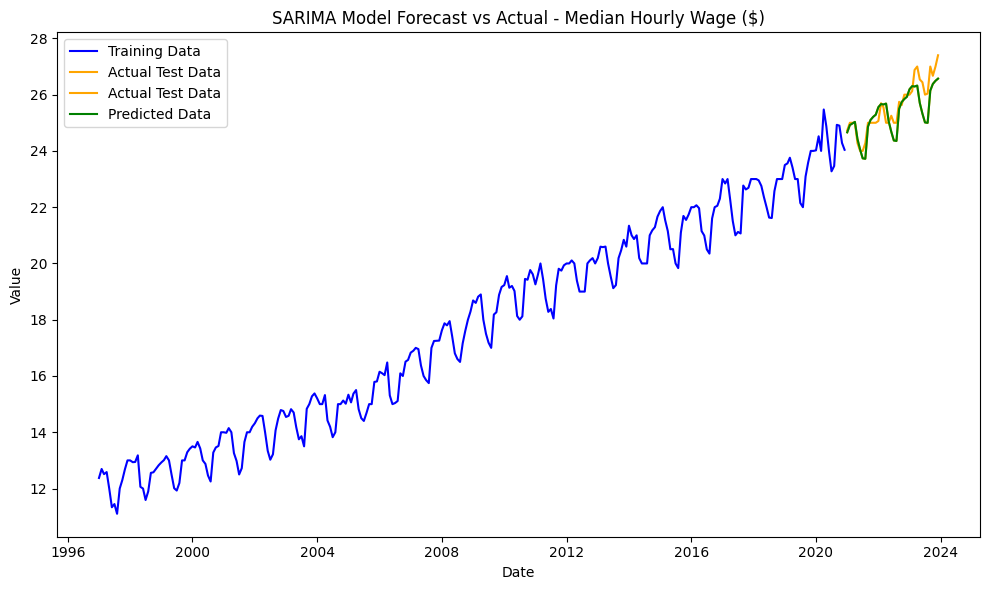

In [19]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training Data', color='blue', linewidth=1.5)
plt.plot(test.index, test, label='Actual Test Data', color='orange', linewidth=1.5)
plt.plot(test.index, test['Predicted'], label='Predicted Data', color='green', linewidth=1.5)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Model Forecast vs Actual - Median Hourly Wage ($)')
plt.legend()
plt.tight_layout()  
plt.show()


## Model Evaluation

Mean Squared Error (MSE): 0.25495466879483375
Root Mean Squared Error (RMSE): 0.5049303603417344
Mean Absolute Error (MAE): 0.3847181091144766
Mean Absolute Percentage Error (MAPE): 1.4854166023035773


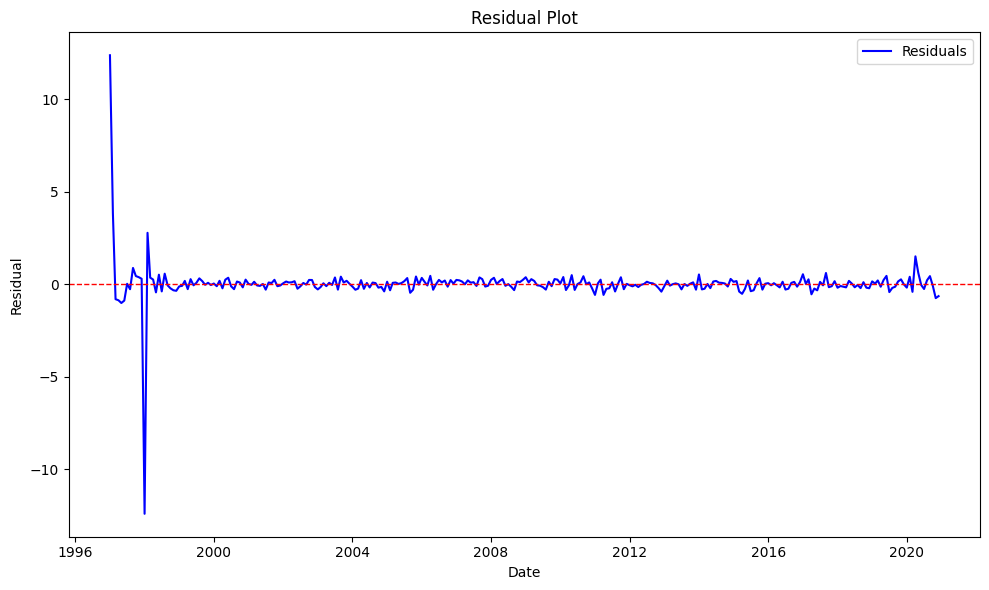

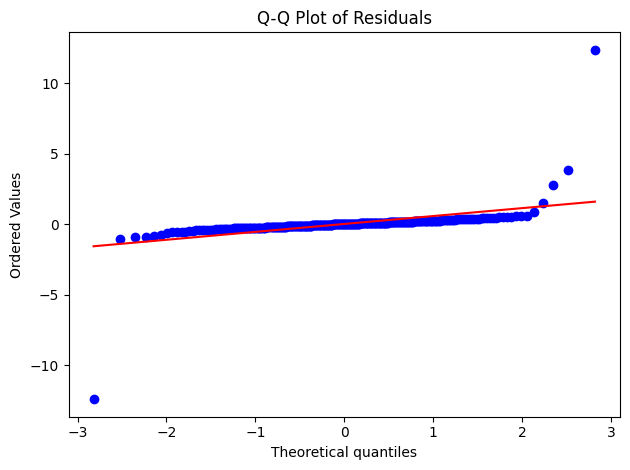

In [20]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test['median_wage'], test['Predicted'])
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test['median_wage'], test['Predicted'])
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Absolute Percentage Error (MAPE)
epsilon = 1e-10  # To avoid division by zero
filtered_test_data = test[test['median_wage'] > epsilon]  # Filter out values near zero
filtered_actual = filtered_test_data['median_wage']
filtered_predicted = filtered_test_data['Predicted']

if len(filtered_actual) > 0:
    mape = np.mean(np.abs((filtered_actual - filtered_predicted) / (filtered_actual + epsilon))) * 100
else:
    mape = np.nan

print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Plot residuals
residuals = model_fit.resid  # Residuals from SARIMA model fit
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals', color='blue')
plt.axhline(0, linestyle='--', color='red', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.legend()
plt.tight_layout()
plt.show()

# Q-Q plot for normality check
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

# Overall Model Selection

The AIC and BIC models were both run and achieved similar results. However, the AIC resulted in lower MSE, RMSE, MAE, and MAPE values, indicating slightly better results. Therefore, the AIC parameters were selected for the SARIMA model on wage rate ($). 

## BIC Model Statistics

*Best SARIMA model:* (0, 1, 2)x(0, 1, 1, 12) with **BIC: 64.46**

**Model Evaluation Results:**

Mean Squared Error (MSE): 0.39184275771208715

Root Mean Squared Error (RMSE): 0.6259734480887246

Mean Absolute Error (MAE): 0.4547943948512361

Mean Absolute Percentage Error (MAPE): 1.7479088044829696